# Continuous Control Project (DDPG)
---
An DDPG agent to solve the Continuous Control Project as part of [Udacity's Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import math 
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from agent import Agent

from unityagents import UnityEnvironment

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below. Depending on the operating system, the ``REACHER_PATH`` to the Unity environment migth need to change.

In [2]:
REACHER_PATH = "Reacher20.app"

env = UnityEnvironment(file_name=REACHER_PATH, worker_id=1, seed=1) # Otherwise Unity crashes...
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=False)[brain_name]

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

states = env_info.vector_observations
state_size = states.shape[1]
num_agents = states.shape[0]

print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
print('The state for the first agent looks like:', states[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of actions: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.98051071e+00 -1.00000000e+00
  5.58052063e-01  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.48525572e-01]


### 3. Simplify the Interface of the Environment

The environment returns a ``BrainInfo`` object with attributes for the new state, the reward, and other information. The following helper function unpacks the values for ``next_state``, ``reward``, and ``done``.

In [3]:
def open_brain_surgery(brain):
    """Helper function to unpack BrainInfo Object.
    
    Params
    ======
        brain (BrainInfo) : Single BrainInfo Object
    """
    next_state = brain.vector_observations
    reward = brain.rewards
    done = brain.local_done
    return (next_state, reward, done)

### 4. Define the Training Function

The cell below trains the agent from scratch and saves the checkpoints when the environment is solved (score > 30).

In [4]:
def train(n_episodes=2000, max_t=1000, highscore=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        highscore (bool): If True training continues after the environment has been solved
    """
    max_score = 29                     # keep track of highest winning score
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        state, _, _ = open_brain_surgery(env.reset(train_mode=True)[brain_name])
        score = 0
        scores_agents = np.zeros(num_agents) 
        agent.reset()
        for t in range(max_t):
            action = agent.act(state)
            next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
            agent.step(state, action, reward, next_state, done)
            state = next_state
            scores_agents += reward
            if np.any(done):
                break 
        score = np.mean(scores_agents)    # calculate mean score over agents
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        avg_score = np.mean(scores_window)
        if i_episode % 1 == 0:          # report training progress
            print('\rEpisode {}\t Episode Score: {:.2f}, Average Score: {:.2f}'.format(i_episode, score, avg_score))
        if math.floor(avg_score)>max_score:
            if max_score == 29:           # environment solved (the average score is rounded down)
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            else:                         # new high score achieved
                print('\nNew high score after {:d} episodes!\tAverage Score: {:.2f}\n'.format(i_episode-100, avg_score))
            max_score = math.floor(avg_score)
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            if not highscore:
                break
    return scores


def plot_scores(scores):
    """Plot Scores.
    
    Params
    ======
        scores (list): list of score for each episode
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

### 5. Train the Agents

The ``Agent`` class contains the DDPG agent.

The number of layers (at least one) and their neurons for the actor and the critic networks can be passed in lists to the ``hidden_sizes_actor`` and ``hidden_sizes_critic`` parameters. The default is ``hidden_sizes_actor = [64,64]`` for the actor, i.e., two layers with 64 neurons each, and ``hidden_sizes_critic = [128, 64, 32]`` for the critic.

Hyperparameters for the learning process can be changed at the beginning of the ``agent.py`` file and are set to:

- ``BUFFER_SIZE = int(1e5)``

- ``BATCH_SIZE = 128``

- ``GAMMA = 0.99``

- ``TAU = 1e-2``

- ``LR_ACTOR = 1e-4``

- ``LR_CRITIC = 1e-3``

- ``WEIGHT_DECAY_AC = 0``

- ``WEIGHT_DECAY_CR = 0``

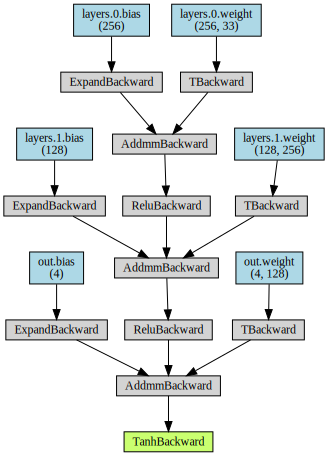

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, 
              random_seed=0, num_agents=num_agents, 
              hidden_sizes_actor=[256,128], hidden_sizes_critic=[128, 64, 32])
agent.show_actor_local()

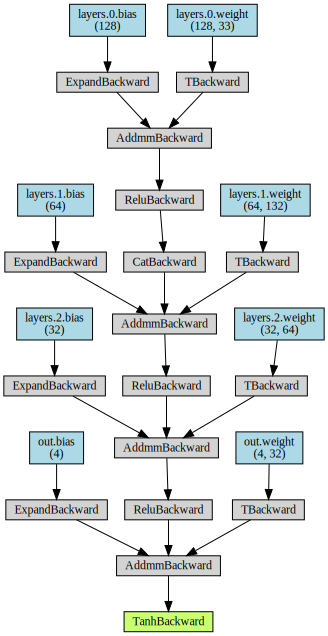

In [7]:
agent.show_critic_local()

Episode 1	 Episode Score: 0.72, Average Score: 0.72
Episode 2	 Episode Score: 0.92, Average Score: 0.82
Episode 3	 Episode Score: 0.97, Average Score: 0.87
Episode 4	 Episode Score: 0.97, Average Score: 0.90
Episode 5	 Episode Score: 1.31, Average Score: 0.98
Episode 6	 Episode Score: 1.16, Average Score: 1.01
Episode 7	 Episode Score: 1.04, Average Score: 1.01
Episode 8	 Episode Score: 1.47, Average Score: 1.07
Episode 9	 Episode Score: 1.39, Average Score: 1.11
Episode 10	 Episode Score: 1.59, Average Score: 1.15
Episode 11	 Episode Score: 1.90, Average Score: 1.22
Episode 12	 Episode Score: 2.75, Average Score: 1.35
Episode 13	 Episode Score: 3.17, Average Score: 1.49
Episode 14	 Episode Score: 3.62, Average Score: 1.64
Episode 15	 Episode Score: 4.95, Average Score: 1.86
Episode 16	 Episode Score: 5.34, Average Score: 2.08
Episode 17	 Episode Score: 5.13, Average Score: 2.26
Episode 18	 Episode Score: 6.08, Average Score: 2.47
Episode 19	 Episode Score: 6.91, Average Score: 2.70
Ep

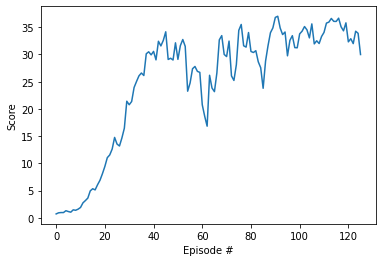

In [8]:
scores = train()
plot_scores(scores)

In [9]:
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

### 6. Watch the Trained Agents

The next cell loads the checkpoint for a trained agent to watch it in action.

In [2]:
# load the weights from file
def watch_agent(agent, max_t=1000, file_name_actor = None, file_name_critic = None):
    """Watch Trained Agent.
    
    Params
    ======
    max_t (int): maximum number of time steps to watch
    file_name_actor (path): path to a trained actor compatible with the agent (optional)
    file_name_critic (path): path to a trained critic compatible with the agent (optional)
    """
    if file_name_actor is None:
        file_name_actor = 'checkpoint_actor.pth'
    if file_name_critic is None:
        file_name_critic = 'checkpoint_critic.pth'
        
    # Load weights
    agent.actor_local.load_state_dict(torch.load(file_name_actor))
    agent.critic_local.load_state_dict(torch.load(file_name_critic))

    # Initiate and run            
    state, _, _ = open_brain_surgery(env.reset(train_mode=False)[brain_name])
    scores_agents = np.zeros(num_agents) 
    agent.reset()
    for t in range(max_t):
        action = agent.act(state)
        next_state, reward, done = open_brain_surgery(env.step(action)[brain_name])
        agent.step(state, action, reward, next_state, done)
        state = next_state
        scores_agents += reward
        if np.any(done):
            break 
    score = np.mean(scores_agents)
    print('Game score: {}'.format(score))
    
watch_agent(agent)

Game score: 3.5924999197013676


In [11]:
env.close()

### 7. Possible Extensions

Performance and training speed could potentially be increased further:


In [12]:
# TODO: add possible extensions